# Robots that learn how to learn

TEAM MEMBER 1 = Bart Haak  
TEAM MEMBER 2 = Martin Kirilov  
TEAM MEMBER 3 = Yosef Winatmoko  
TEAM MEMBER 4 = Zeinab Mapar  

In [1]:
# General imports
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures

# Extra imports
from scipy.stats import norm

In [2]:
# Download Wall Robot Navigation data from OpenML.
robot = oml.datasets.get_dataset(1497)
X, y, attribute_names = robot.get_data(target=robot.default_target_attribute, return_attribute_names=True);
labels = ['Move-Forward','Slight-Right-Turn','Sharp-Right-Turn','Slight-Left-Turn']

In [3]:
# Random Forest that also returns the standard deviation of predictions
from sklearn.ensemble import RandomForestRegressor

class ProbabilisticRandomForestRegressor(RandomForestRegressor):
    """
    A Random Forest regressor that can also returns the standard deviations for all predictions
    """
    def predict(self, X, return_std=True):       
        preds = []
        for pred in self.estimators_:
            preds.append(pred.predict(X))
        if return_std:
            return np.mean(preds, axis=0), np.std(preds, axis=0)
        else:
            return np.mean(preds, axis=0)

In [4]:
# Helper function to compute expected improvement 
def EI(surrogate, X: np.ndarray, curr_best=0.0, balance=0.0, **kwargs):
    """Computes the Expected Improvement
    surrogate, The surrogate model
    X: np.ndarray(N, D), The input points where the acquisition function
        should be evaluated. N configurations with D hyperparameters
    curr_best, The current best performance
    balance, Decrease to focus more on exploration, increase to focus on exploitation (optional)
    Returns
    -------
    np.ndarray(N,1), Expected Improvement of X
    """
    if len(X.shape) == 1:
        X = X[:, np.newaxis]

    m, s = surrogate.predict(X) # mean, stdev

    z = (curr_best - m - balance) / s
    f = (curr_best - m - balance) * norm.cdf(z) + s * norm.pdf(z)

    if np.any(s == 0.0): # uncertainty should never be exactly 0.0
        f[s == 0.0] = 0.0

    return f

## Questions

Basic imports

In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import GPy
import itertools
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import time
import random; random.seed(1337)

# 1 Gaussian Processes (5 points)
* Implement Bayesian optimization using Gaussian Processes for the surrogate model and use it to optimize the hyperparameters of an SVM for the robot navigation training data
    - The evaluation measure should be misclassification error (1 - Accuracy), evaluated using 3-fold cross-validation
    - The hyperparameters and ranges are the same as in question 1, but sampled from a log scale (`numpy.logspace`) rather than a grid 

In [6]:
class GPWrapper(object):
    """
    A wrapper class to make GP functions callable with fit() and predict()
    """
    def __init__(self, kernel):
        self.kernel = kernel

    def fit(self, X, y):
        self.m = GPy.models.GPRegression(X, y, self.kernel)
        self.m.optimize()

    def predict(self, X):
        mean, var = self.m.predict(X)
        return (mean, np.sqrt(var))

In [7]:
class SVMOptimizer(object):
    """
    Handle SVM hyperparameter optimization based on selected surrogate model
    """

    def __init__(self, estimator, surrogate, X, y, configs, EI_balance=0):
        self.estimator = estimator
        self.X, self.y = X, y
        self.configs = configs
        self.param_grid = list(itertools.product(
            configs['C'], configs['gamma']))
        self.surrogate = surrogate
        self.EI_balance = EI_balance

        self.evals = []
        self.log = []
        self._EI_idx_evaluated = []

    def process(self):
        """
        Evaluate chosen config(s) of SVM and use the performance as
        new data point for surrogate model. Fit surrogate model with
        additional config and calculate expected improvement.
        """
        time_start = time.perf_counter()

        # evaluate new config(s) with estimator
        for config in self.chosen_config[-1]:
            self.estimator.set_params(**config)
            score = 1 - cross_val_score(self.estimator,
                                        self.X, self.y, cv=3, scoring='accuracy')
            self.evals.append([config['C'], config['gamma'], score.mean()])

        # fit surrogate model
        evals_arr = np.asarray(self.evals, dtype=np.float64)
        X_surr = np.log2(evals_arr[:, :-1])
        y_surr = evals_arr[:, -1].reshape(-1, 1)
        self.surrogate.fit(X_surr, y_surr)

        # calculate EI for all params
        self.EI_pred = EI(self.surrogate, np.log2(self.param_grid),
                          balance=self.EI_balance,
                          curr_best=np.min([e[2] for e in self.evals])).ravel()

        time_end = time.perf_counter()
        return time_end - time_start

    def run_initial(self, n=10):
        """
        Prepare n initial random configurations, 
        do 1 iteration of process
        """
        # initialize n configs
        self.chosen_config = [[]]
        rand_idx = np.random.choice(len(self.param_grid), n)
        for i in rand_idx:
            self.chosen_config[0].append({
                'C': self.param_grid[i][0],
                'gamma': self.param_grid[i][1]
            })
            self._EI_idx_evaluated.append(i)

        # begin process with initial config
        processing_time = self.process()

        # logging
        return self.logging(processing_time)

    def next_iter(self):
        """
        Prepare new config based on highest expected improvement,
        do 1 iteration of process
        """

        # get new config with highest EI
        for i in self._EI_idx_evaluated:
            self.EI_pred[i] = 0   # ignore evaluated config
        max_EI_idx = np.argwhere(self.EI_pred == np.amax(self.EI_pred))[0]
        argmax_EI = max_EI_idx[random.randint(0, len(max_EI_idx)-1)]
        self._EI_idx_evaluated.append(argmax_EI)

        # add new config to list to evaluate
        self.chosen_config.append([{
            'C': self.param_grid[argmax_EI][0],
            'gamma': self.param_grid[argmax_EI][1]
        }])

        # begin process with new config
        processing_time = self.process()

        # logging
        return self.logging(processing_time, argmax_EI)

    def logging(self, processing_time, argmax_EI=None):
        """
        Append new process log to logging array,
        used to evaluate processing time
        """
        eval_idx = np.argmin([e[2] for e in self.evals])
        process_log = {
            'new_config': None if argmax_EI is None else self.param_grid[argmax_EI],
            'new_config_EI': 0 if argmax_EI is None else self.EI_pred[argmax_EI],
            'time_lapsed': processing_time,
            'best_config': (self.evals[eval_idx][0], self.evals[eval_idx][1]),
            'best_error': self.evals[eval_idx][2],
        }
        self.log.append(process_log)
        return self.log[-1]

    def plot(self, iter_no):
        """
        Plot the prediction contour of surrogate model
        and the respective expected improvement
        """
        X_surr = np.log2(np.asarray(self.param_grid))
        mu, var = self.surrogate.predict(X_surr)

        C_eval = [ev[0] for ev in self.evals]
        gamma_eval = [ev[1] for ev in self.evals]
        contour_C, contour_gamma = np.meshgrid(
            self.configs['C'], self.configs['gamma'])

        fig = plt.figure(figsize=(15, 5))
        fig.suptitle('Iteration #' + str(iter_no))

        ax1 = fig.add_subplot(1, 2, 1)
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1_contour = ax1.contour(contour_C, contour_gamma,
                                  mu.reshape(len(self.configs['gamma']), len(
                                      self.configs['C'])),
                                  linewidths=1.2, zorder=-1)
        ax1.autoscale(False)
        ax1_scatter = ax1.scatter(
            gamma_eval, C_eval, c='black', s=25, zorder=1)
        _ = ax1.clabel(ax1_contour, inline=1, fontsize=10)
        _ = ax1.set_title('Surrogate Model Predicted Mean Error')
        _ = ax1.set_xlabel('gamma')
        _ = ax1.set_ylabel('C')

        ax2 = fig.add_subplot(1, 2, 2)
        ax2.set_xscale('log')
        ax2.set_yscale('log')
        ax2_pc = ax2.pcolor(self.configs['C'], self.configs['gamma'],
                            self.EI_pred.reshape(
                                len(self.configs['C']), len(self.configs['gamma'])),
                            cmap=cm.copper, zorder=-1)
        ax2.autoscale(False)
        ax2_scatter = ax2.scatter(
            gamma_eval, C_eval, c='white', s=25, zorder=1)
        _ = fig.colorbar(ax2_pc)
        _ = ax2.set_title('Expected Improvement')
        _ = ax2.set_xlabel('gamma')
        _ = ax2.set_ylabel('C')

* Initialize the surrogate model with 10 randomly sampled configurations and visualize the surrogate model.
* Visualize the resulting acquisition function, either as 2D slices or a 3D surface

We choose balance = -0.5 for the expected improvement because when we use default parameter, the model immediately exploit the area with low error score from the initial configurations. Instead, we want to impose more explorative behavior in the algorithm for a better expected improvement visualization.

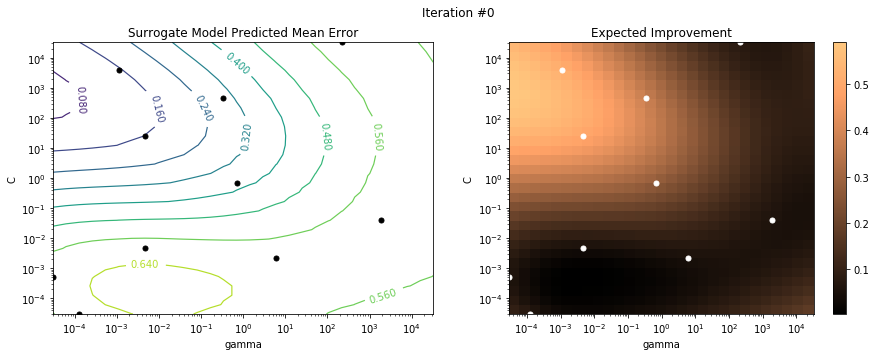

In [8]:
np.random.seed(434)
param_logspace = np.logspace(-15, 15, num=30, base=2)

param_config = {
    'C' : param_logspace,
    'gamma' : param_logspace
}

kern = GPy.kern.RBF(2)
gp = GPWrapper(kern)
optimizer = SVMOptimizer(SVC(), gp, X, y, configs=param_config, EI_balance=-0.5)

# 1st iteration
opt_run = optimizer.run_initial(n=10)
optimizer.plot(iter_no=0)

In [9]:
def plot_slices(opt, fix_c, fix_gamma, param_grid):
    fig = plt.figure(figsize=(15, 5))
    _ = fig.suptitle('2D Slices of Predicted Mean Error and Expected Improvement')

    # calculate with Fix C
    fix_c_arr = np.full(len(param_grid['gamma']), np.log2(fix_c)).reshape(-1, 1)
    X_surr_c = np.concatenate(
        [fix_c_arr, np.log2(param_grid['gamma']).reshape(-1, 1)], axis=1)
    mu_c, std_c = opt.surrogate.predict(X_surr_c)

    # plot C slice
    ax1 = fig.add_subplot(2, 2, 1)
    _ = ax1.set_title('Slice at C = {}'.format(fix_c))
    _ = ax1.set_ylabel('Surrogate model error')
    _ = ax1.set_xscale('log')
    _ = ax1.plot(param_grid['gamma'],
                 mu_c, 'b-', markersize=10, label=u'Mean')
    _ = ax1.fill_between(param_grid['gamma'],
                         (mu_c-2*std_c).ravel(),
                         (mu_c+2*std_c).ravel(),
                         alpha=0.1, label='Confidence')

    # plot C slice acquisition function
    EI_c = EI(opt.surrogate, X_surr_c, balance=opt.EI_balance,
                              curr_best=np.min([e[2] for e in opt.evals]))
    ax3 = fig.add_subplot(2, 2, 3)
    _ = ax3.set_xscale('log')
    _ = ax3.set_xlabel('Gamma value')
    _ = ax3.set_ylabel('Expected Improvement')
    _ = ax3.plot(param_grid['gamma'], EI_c)

    # calculate with Fix gamma
    fix_gamma_arr = np.full(len(param_grid['C']), np.log2(fix_gamma)).reshape(-1, 1)
    X_surr_gamma = np.concatenate(
        [np.log2(param_grid['C']).reshape(-1, 1), fix_gamma_arr], axis=1)
    mu_gamma, std_gamma = opt.surrogate.predict(X_surr_gamma)

    # plot gamma slice
    ax2 = fig.add_subplot(2, 2, 2)
    _ = ax2.set_title('Slice at gamma = {}'.format(fix_gamma))
    _ = ax2.set_xscale('log')
    _ = ax2.plot(param_grid['C'],
                 mu_gamma, 'b-', markersize=10, label=u'Mean')
    _ = ax2.fill_between(param_grid['gamma'],
                         (mu_gamma-2*std_gamma).ravel(),
                         (mu_gamma+2*std_gamma).ravel(),
                         alpha=0.1, label='Confidence')

    # plot gamma slice acquisition function
    EI_gamma = EI(opt.surrogate, X_surr_gamma, balance=opt.EI_balance,
                              curr_best=np.min([e[2] for e in opt.evals]))
    ax4 = fig.add_subplot(2, 2, 4)
    _ = ax4.set_xscale('log')
    _ = ax4.set_xlabel('C value')
    _ = ax4.plot(param_grid['gamma'], EI_gamma)

2D slices of the parameters and the expected improvement

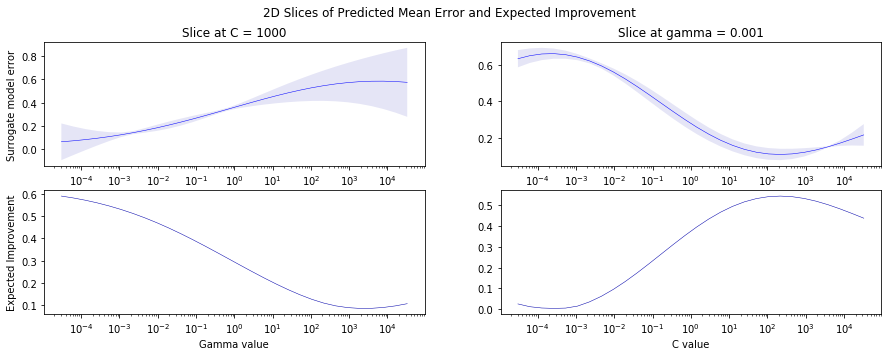

In [10]:
plot_slices(optimizer, fix_c=10**3, fix_gamma=10**-3, param_grid=param_config)

* Visualize 3 more iterations, each time visualizing the surrogate model and acquisition function

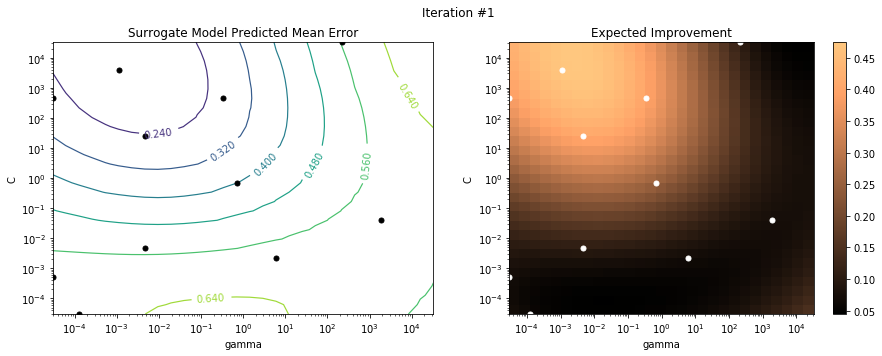

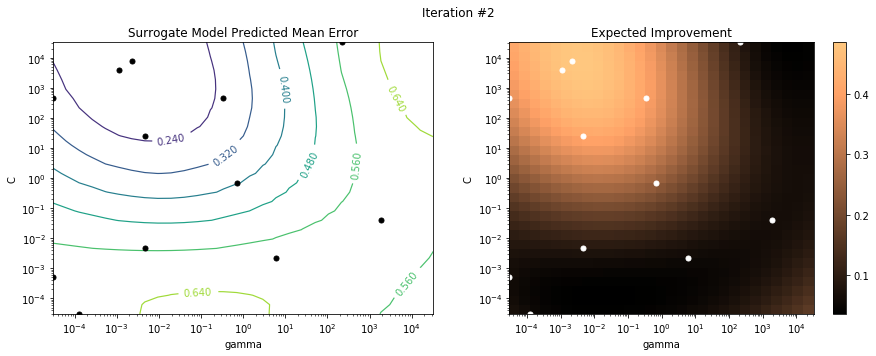

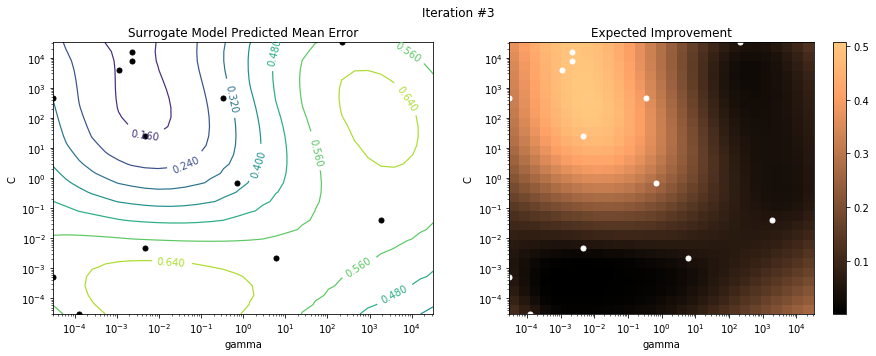

In [11]:
for i in range(3):
    opt_run = optimizer.next_iter()
    optimizer.plot(iter_no=i+1)

* Run the Bayesian optimization for at least 30 iterations, report the optimal configuration and show the final surrogate model (2D slices or 3D surface).

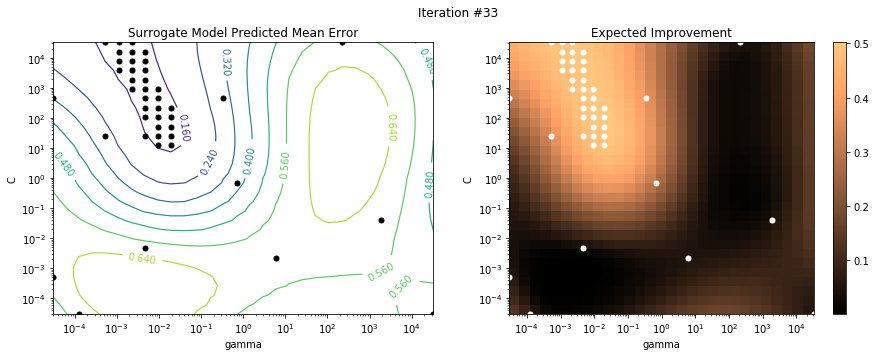

In [12]:
for i in range(30):
    opt_run = optimizer.next_iter()
optimizer.plot(iter_no=33)

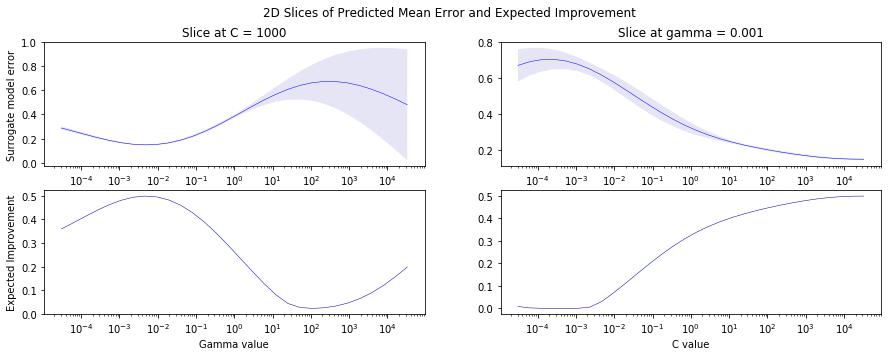

In [14]:
plot_slices(optimizer, fix_c=10**3, fix_gamma=10**-3, param_grid=param_config)

In [15]:
print('Best C and gamma: {}'.format(optimizer.log[-1]['best_config']))
print('Best misclassification error score: {}'.format(optimizer.log[-1]['best_error']))

Best C and gamma: (51.61273483249169, 0.019375063213477938)
Best misclassification error score: 0.14640993403369643


* Interpret and explain the results. Does Bayesian optimization efficiently find good configurations? It is more efficient than a random search?

As we can observe from iteration #0, the gaussian processes prediction with 10 initial configurations already resemble the true result known from grid search (from A2Q1) to some extent. Looking at the subsequent chosen configurations after initialization, bayesian optimization quickly converge to area where the configurations give the best results. Since iteration #2, it has found the area with the best scores and begin exploitting it, even when the balance configuration is set to -0.5 (favor explore more). Therefore, for this case, bayesian optimization is more efficient compared to blind search because it takes prior experiences into account.

# 2 Comparison with Random Search (2 points)
* Show the sequence of the selected Bayesian optimization configurations superimposed on the 2D heatmap from question 1, part 1. Label the initial 10 configuration as '0', the next one as '1', and so on.

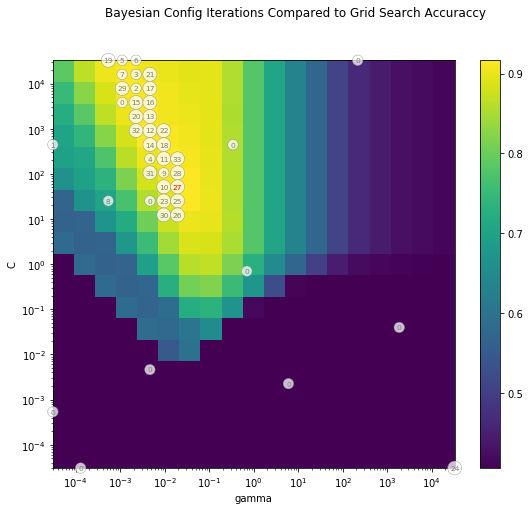

In [16]:
# read grid search results from A2Q1
gridsearch_results = pd.read_csv('gridsearch_results.csv')
gs_df = pd.pivot_table(gridsearch_results, values='score', index='C', columns='gamma')

def superimpose_heatmap(gridsearch_df, optimizer):
    fig = plt.figure(figsize=(9, 7.5))
    _ = fig.suptitle('Bayesian Config Iterations Compared to Grid Search Accuraccy')
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax_pc = ax.pcolor(gridsearch_df.index.values, gridsearch_df.columns.values, gridsearch_df.values)
    _ = fig.colorbar(ax_pc)
    _ = ax.set_xlabel('gamma')
    _ = ax.set_ylabel('C')

    best_config = optimizer.log[-1]['best_config']
    for i, configs in enumerate(optimizer.chosen_config):
        for config in configs:
            if (config['C'] == best_config[0] and config['gamma'] == best_config[1]):
                text_color = "red"
            else:
                text_color = "grey"
            bcircle = dict(boxstyle="circle", fc="white", ec="grey", lw=0.5, alpha=0.75)
            t = ax.text(config['gamma'], config['C'], str(i), ha="center", va="center", 
                        size=7.5, color=text_color, bbox=bcircle)

superimpose_heatmap(gs_df, optimizer)

*Red-colored number* shows the optimal parameter.

* Time how long the Bayesian optimization takes, and compare this to a simple random search with at least 30 iterations

When we compare only 1 instance of random search with 1 instance of bayesian optimization, we found that the comparison depends heavily on the 10 initial configurations of bayesian optimization and thus we deemed the result is not fit as a basis of judgement if bayesian optimization is more efficient compared to random search. Instead of comparing only 1 instance each, we decide to do 10 instances for each method and take the mean processing time and best error for each iterations of each method.

In [17]:
def SVM_random_search(param_grid, n=30):
    all_configs = list(itertools.product(param_grid['C'], param_grid['gamma']))
    chosen_configs = random.sample(all_configs, n)
    evals = []
    log = []
    svc = SVC()
    for config in chosen_configs:
        time_start = time.perf_counter()
        svc.set_params(**{'C':config[0], 'gamma':config[1]})
        score = np.mean(1 - cross_val_score(svc, X, y, cv=3, scoring='accuracy'))
        time_end = time.perf_counter()
        evals.append((config[0], config[1], score))
        eval_idx = np.argmin([e[2] for e in evals])
        log.append({
            'time_lapsed': time_end - time_start,
            'best_config': (evals[eval_idx][0], evals[eval_idx][1]),
            'best_error': evals[eval_idx][2],
        })
    return log

Because we assume first 10 configs as initialization, use 40 random configs instead of 30.

In [18]:
rand_logs = []
# do 10 random searches
for i in range(10):
    rand_logs.append(SVM_random_search(param_config,40))

In [19]:
bayesian_logs = []
# do 10 bayesian optimizations
for i in range(10):
    kern = GPy.kern.RBF(2)
    gp = GPWrapper(kern)
    optimizer = SVMOptimizer(SVC(), gp, X, y, configs=param_config)
    opt_run = optimizer.run_initial(n=10)
    for j in range(30):
        opt_run = optimizer.next_iter()
    bayesian_logs.append(optimizer.log)

* Plot the runtime (X-axis) against the performance (Y-axis), as a line with one point for every iteration (runtime and best configuration found thus far). It should show how fast each method converges to the optimal solution.

In [20]:
def plot_performance(logs, ax, label, color):
    res_ts = []
    res_best_error = []
    for log in logs:
        tl_x = [e['time_lapsed'] for e in log]
        res_ts.append(np.cumsum(tl_x) - tl_x[0])
        res_best_error.append([e['best_error'] for e in log])

    ts = np.mean(np.asarray(res_ts), axis=0)
    avg_error = np.mean(np.asarray(res_best_error), axis=0)
    std_error = np.std(np.asarray(res_best_error), axis=0)
    _ = ax.plot(ts, avg_error, '-', color=color, zorder=2, label=label)
    _ = ax.scatter(ts, avg_error, color=color, s=7, zorder=3, label='{} iterations'.format(label))
    _ = ax.fill_between(ts,avg_error-2*std_error,avg_error+2*std_error, color=color,
                         alpha=0.1, label='{} 95% CI'.format(label), zorder=1)

Since bayesian optimization get 10 initial configurations randomly, we ignore the first 10 iterations for random search as well because both are essentially doing the same initialization; any difference in performance and processing time of the initialization are due to external factors. Hence, for random search, the first iteration data point shows the result after 10 initial configurations instead, similar with the bayesian optimizations.

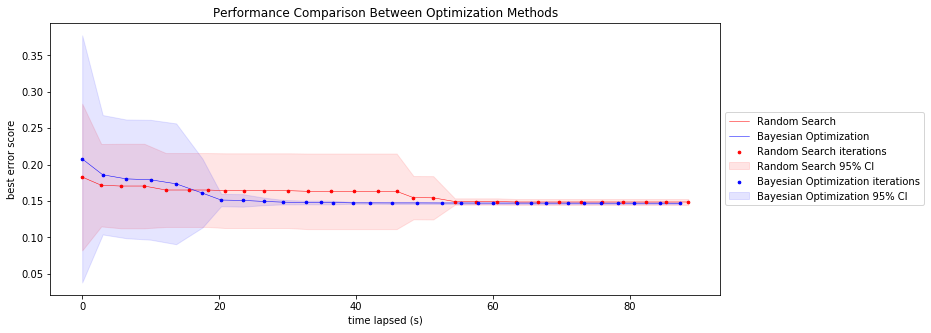

In [21]:
# exclude the first n initial configurations
cut_rand_logs = [log[10:] for log in rand_logs]

fig = plt.figure(figsize=(12, 5))

_ = fig.suptitle('')
ax = fig.add_subplot(1, 1, 1)
_ = ax.set_xlabel('time lapsed (s)')
_ = ax.set_ylabel('best error score')
_ = ax.set_title('Performance Comparison Between Optimization Methods')

plot_performance(cut_rand_logs, ax, 'Random Search', 'red')
plot_performance(bayesian_logs, ax, 'Bayesian Optimization', 'blue')

_ = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

* Interpret and discuss the results. Is it worth doing the Bayesian optimization or is a random search sufficient? 

As shown in the performance comparison, bayesian optimizations can find the optimal configurations faster compared to random searches. Moreover, as expected from random search, the confidence interval is wider than bayesian optimization. All bayesian optimizations have found the optimal configurations only in around 25 seconds, whereas random searches spent on average 50 seconds (excluding the training for 10 initial configurations). Therefore, bayesian optimization is worth doing because it saves time significantly (50%) in this case.

# 3 Random Forests (3 points)
* Repeat the previous 2 parts, but now using Random Forests as the surrogate model.

Begin with the initial 10 configurations.

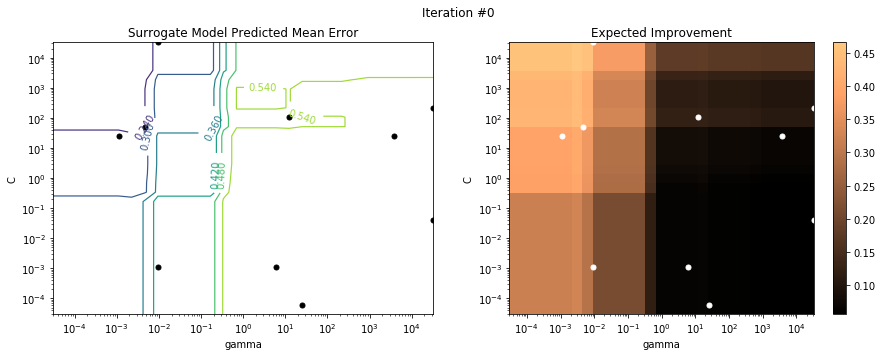

In [26]:
np.random.seed(433)
param_logspace = np.logspace(-15, 15, num=30, base=2)

param_config = {
    'C' : param_logspace,
    'gamma' : param_logspace
}

prf = ProbabilisticRandomForestRegressor(n_estimators=100)
optimizer_prf = SVMOptimizer(SVC(), prf, X, y, configs=param_config, EI_balance=-0.5)

# 1st iteration
opt_run = optimizer_prf.run_initial(n=10)
optimizer_prf.plot(iter_no=0)

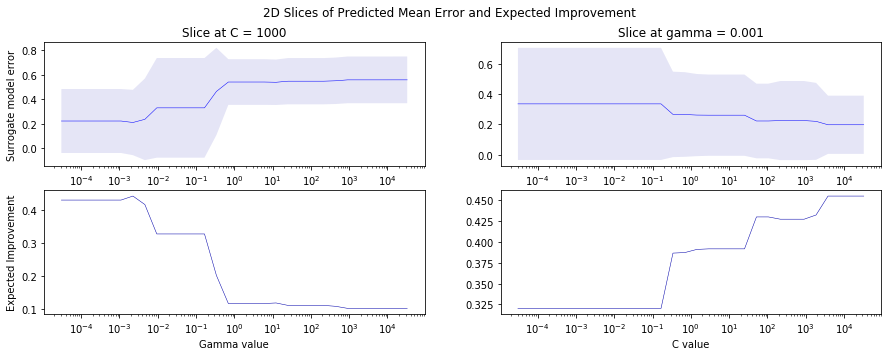

In [27]:
plot_slices(optimizer_prf, fix_c=10**3, fix_gamma=10**-3, param_grid=param_config)

Do 3 more iterations and visualize the predicted error value and acquisition function.

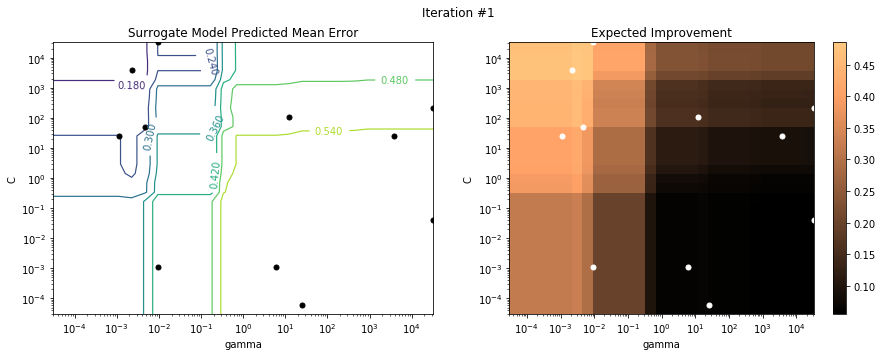

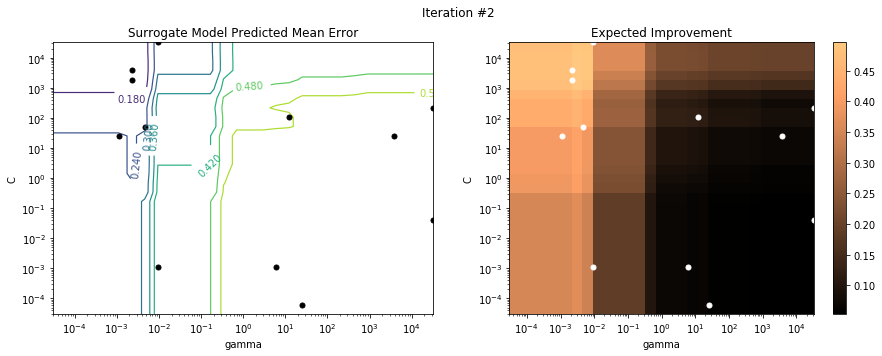

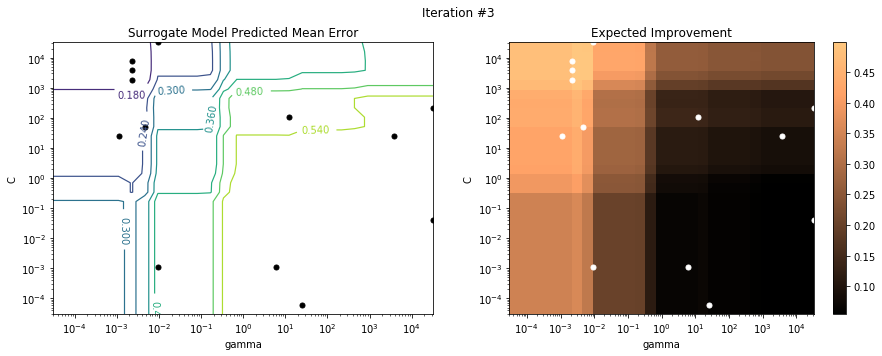

In [28]:
# 3 more iterations
for i in range(3):
    opt_run = optimizer_prf.next_iter()
    optimizer_prf.plot(iter_no=i+1)

Do 30 more iterations and visualize the predicted error value and acquisition function.

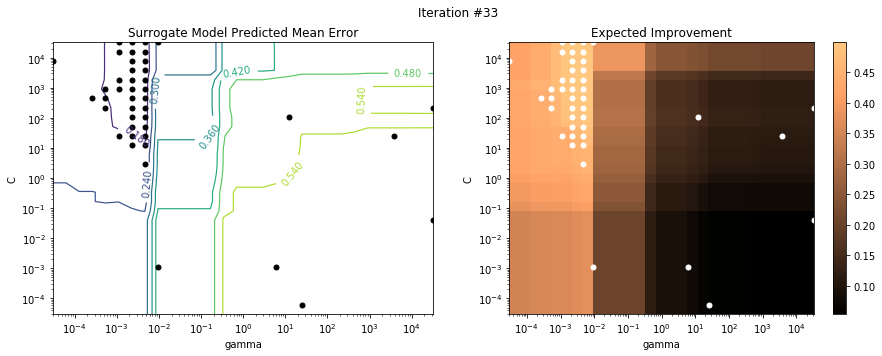

In [29]:
# run 30 iterations
for i in range(30):
    opt_run = optimizer_prf.next_iter()
optimizer_prf.plot(iter_no=33)

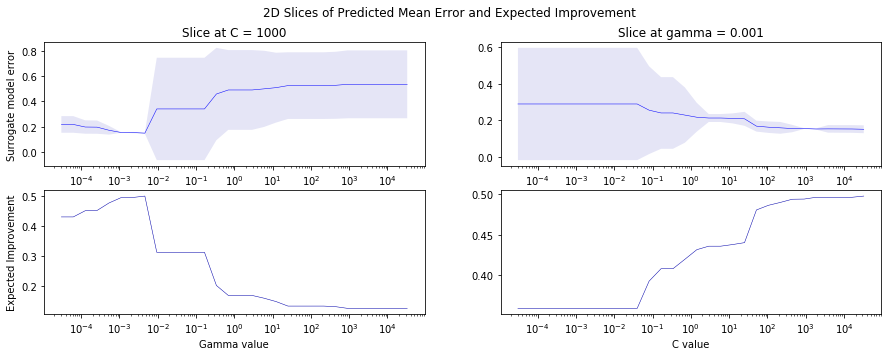

In [30]:
plot_slices(optimizer_prf, fix_c=10**3, fix_gamma=10**-3, param_grid=param_config)

Random forest superimposed on the gridsearch result from A2Q1.

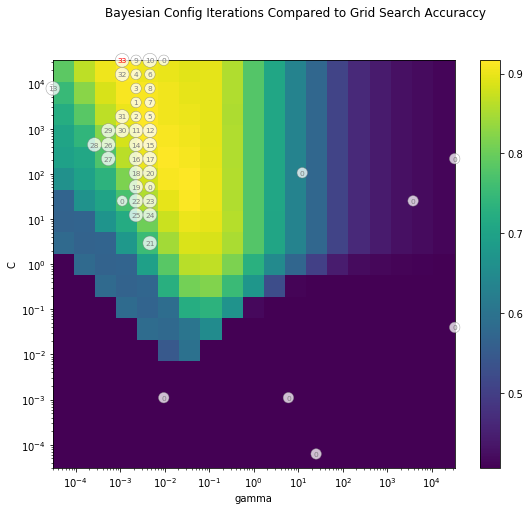

In [31]:
superimpose_heatmap(gs_df, optimizer_prf)

In [32]:
print('Best C and gamma: {}'.format(optimizer_prf.log[-1]['best_config']))
print('Best misclassification error score: {}'.format(optimizer_prf.log[-1]['best_error']))

Best C and gamma: (32768.0, 0.0011005296984690743)
Best misclassification error score: 0.14714152733954713


* Interpret and discuss the results. How is the surrogate model different from the one built with Gaussian Processes?

The most prominent difference is the smoothness of the surrogate error prediction. This is expected, because we use RBF kernel in Gaussian Processes, which assume that the error has some degree of smoothness across the parameters. In contrast, Random forrest regressor is a tree-based model and there is no assumption of smoothness in the error prediction.

* Does the optimization work equally efficient? Does it converge faster than either the Gaussian Processes or random search?

Run 10 instances of Probabilistic RF Regressor to compare with Random Search and Gaussian Processes.

In [33]:
rf_logs = []
for i in range(10):
    prf = ProbabilisticRandomForestRegressor(n_estimators=100)
    optimizer_prf = SVMOptimizer(SVC(), prf, X, y, configs=param_config)
    opt_run = optimizer_prf.run_initial(n=10)
    for j in range(30):
        opt_run = optimizer_prf.next_iter()
    rf_logs.append(optimizer_prf.log)

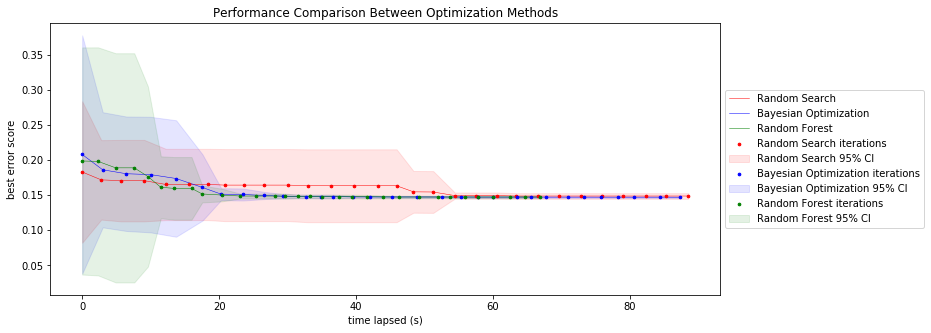

In [35]:
fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(1, 1, 1)
_ = ax.set_xlabel('time lapsed (s)')
_ = ax.set_ylabel('best error score')
_ = ax.set_title('Performance Comparison Between Optimization Methods')

plot_performance(cut_rand_logs, ax, 'Random Search', 'red')
plot_performance(bayesian_logs, ax, 'Bayesian Optimization','blue')
plot_performance(rf_logs, ax, 'Random Forest', 'green')

_ = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Although that the confidence interval for random forest is wider in the beginning, but it converges slightly faster than bayesian optimization.

What do you expect to happen if you need to optimize many more hyperparameters?
1. The difference between using a surrogate model compared to simple random search is the overhead of training the surrogate model. The surrogate model, depends on the complexity, will take longer time to train, whereas it will just be more randomization for random search.
2. The number of possible combination of parameters will increase exponentially, which means the search space for random search will also grow. We expect the probability of random search to arrive at optimal configurations will be smaller.

Considering the processing time for a surrogate model should be miniscule compared to the training time of the actual prediction model, we still expect the bayesian optimization and random forest regressor to converge faster than using random search when there are more hyperparameters to optimize.